In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

In [2]:
np.random.seed(2020)
geshuN=100
mu0=np.array([0.012,0.15,-60,0,0])#0.012 and 0.00083
C0=np.array([[0.00001,0,0,0,0],[0,0.00001,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
z0n=np.random.multivariate_normal(mu0,C0,geshuN)

In [3]:
print(z0n.shape)

(100, 5)


In [4]:
print(z0n[0,:])

[ 1.22389173e-02  1.44406419e-01 -6.00000000e+01  0.00000000e+00
  0.00000000e+00]


In [5]:
# print(z0n)

In [6]:
with open('Abos.pickle','rb+') as f:
    A=pickle.load(f)

In [7]:
with open('Ga_xinhao.pickle','rb+') as f:
    Yt=pickle.load(f)

In [8]:
print(Yt.shape)

torch.Size([10000])


In [9]:
print(A.shape)

(4, 10001)


In [10]:
def generate_property(gu1,gu2):
    # each node contain such property:
    #          E/I, blocked_in_stat, I_extern_Input, sub_block_idx, C, T_ref, g_Li, V_L, V_th, V_reset, g_ui, V_ui, tao_ui
    #   size:  1,   1,               1,                1,           1, 1,     1,    1,   1,    1,       4     4,    4
    #   dtype: b,   b,               f,                i,           f, f,     f,    f,   f,    f,       f,    f,    f
    # b means bool(although storage as float), f means float.

    property = np.zeros([1, 22], dtype=np.float32)
    E_thresh = 1
    property[:, 0] = 1

    property[:, 1] = 0

    property[:, 2] = 0

    property[:, 3] = 0
    property[:, 4] = 1
    property[:, 5] = 5
    property[:, 6] = 0.001
    property[:, 7] = -75
    property[:, 8] = -50
    property[:, 9] = -65

#     g_ui =np.array([5/275, 5/4000, 3/30, 3/730])
    g_ui =np.array([gu1, gu2, 3/60, 3/1460])
    g_ui =g_ui if isinstance(g_ui, np.ndarray) else np.array(g_ui)
    property[:, 10:14] = g_ui
    
    V_ui = np.array([0, 0, -70, -100])
    V_ui =  V_ui  if isinstance(V_ui, np.ndarray) else np.array(V_ui)
    property[:, 14:18] = V_ui
    
    tao_ui =np.array ([2, 40, 10, 50])
#     tao_ui =np.array ([1, 20, 5, 25])
    tao_ui = tao_ui if isinstance(tao_ui, np.ndarray) else np.array(tao_ui)

    property[:, 18:22] = tao_ui
    

    return property

In [11]:
def get_nextgui(node_property,bosong,J_uiold,V_i):
    I_extern_Input = torch.tensor(node_property[:, 2]) # extern_input index , shape[K]
    V_ui =torch.tensor(node_property[:, 14:18].reshape([4,1]))  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
    tau_ui = torch.tensor(node_property[:, 18:22].reshape([4,1]))# shape [K, N]
    g_ui = torch.tensor(node_property[:, 10:14].reshape([4,1])) # shape [K, N]
    g_Li = torch.tensor(node_property[:, 6])  # shape [N]
    V_L = torch.tensor(node_property[:, 7])  # shape [N]
    C = torch.tensor(node_property[:, 4])   # shape [N]
    sub_idx = torch.tensor(node_property[:, 3]) # shape [N]
    V_th = torch.tensor(node_property[:, 8])  # shape [N]
    V_reset = torch.tensor(node_property[:, 9]) # shape [N]
    T_ref = torch.tensor(node_property[:, 5]) # shape [N]
    
    
    J_ui = J_uiold * torch.exp(-1 / tau_ui) #shape:4*1####
    bosong1= torch.tensor(bosong)####产生01的泊松分布
    J_ui_activate_part = bosong1.view(4,1) # !!! this part can be sparse.#####输入一个泊松分布
    J_ui += J_ui_activate_part
    
    return J_ui
    
    
def get_nextvi(node_property,J_ui,V_i):
    I_extern_Input = torch.tensor(node_property[:, 2]) # extern_input index , shape[K]
    V_ui =torch.tensor(node_property[:, 14:18].reshape([4,1]))  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
    tau_ui = torch.tensor(node_property[:, 18:22].reshape([4,1]))# shape [K, N]
    g_ui = torch.tensor(node_property[:, 10:14].reshape([4,1])) # shape [K, N]
    g_Li = torch.tensor(node_property[:, 6])  # shape [N]
    V_L = torch.tensor(node_property[:, 7])  # shape [N]
    C = torch.tensor(node_property[:, 4])   # shape [N]
    sub_idx = torch.tensor(node_property[:, 3]) # shape [N]
    V_th = torch.tensor(node_property[:, 8])  # shape [N]
    V_reset = torch.tensor(node_property[:, 9]) # shape [N]
    T_ref = torch.tensor(node_property[:, 5]) # shape [N]
    
    
    I_ui = g_ui * (V_ui - V_i) * J_ui
        # [K, N]            [K, N] - [K, 1]
    I_syn = I_ui.sum(dim=0)
    
    
    main_part = -g_Li * (V_i - V_L)
    C_diff_Vi = main_part + I_syn + I_extern_Input
    delta_Vi = 1 / C * C_diff_Vi

    Vi_normal = V_i + delta_Vi 
    V_i = torch.min(Vi_normal,V_th)
    
    return V_i
    

    
    

In [12]:
#定义函数zj+1,n=g(zj,n)+noise
alfa=0.1
beta=0.1
yita=0.1
J=200
J_ui=torch.zeros([4, 1])
znextn=torch.zeros([geshuN,5])
z1n=torch.zeros([geshuN,5])
zn_outcome=torch.zeros([geshuN,5])
zn_outcome=z0n
z1n=z0n
k=np.ones(geshuN).reshape((geshuN,1))
a_allout=[]
H=np.array([0,0,0,0,1])
H=H.reshape((1,5))
H_t=H.reshape((5,1))
gama=0.05#观测数据的噪声
Yt=np.array(Yt)

for i in range(J):
    znextn=zn_outcome
    bosong=A[:,i]
    zn_outcome=copy.deepcopy(zn_outcome)
    a_allout.append(zn_outcome)
#     print(zn_outcome[0,:])
    
    for j in range(geshuN):###geshuN
        propertyy=generate_property(znextn[j,0],znextn[j,1])
        V_i=znextn[j,2]
        if V_i>=-50:
            z0n[j,2]=-65
            k[j,0]=1
            J_ui=get_nextgui(propertyy,bosong,J_ui,V_i)
        elif V_i==-65:
            if k[j,0]<4:
                z0n[j,2]=-65
                k[j,0]=k[j,0]+1
                J_ui=get_nextgui(propertyy,bosong,J_ui,V_i)
            else:
                V_i=get_nextvi(propertyy,J_ui,V_i)
                J_ui=get_nextgui(propertyy,bosong,J_ui,V_i)
                z0n[j,2]=V_i
        else:
            V_i=get_nextvi(propertyy,J_ui,V_i)
            J_ui=get_nextgui(propertyy,bosong,J_ui,V_i)
            z0n[j,2]=V_i
        z0n[j,0]=znextn[j,0]
        z0n[j,1]=znextn[j,1]
        if z0n[j,2]==-50:
            z0n[j,3]=yita*znextn[j,3]+1
        else:
            z0n[j,3]=znextn[j,3]
            
        z0n[j,4]=alfa*(z0n[j,3]+beta)
#         print("迭代后:",z0n[j,:])
        C1=np.array([[0.00001,0,0,0,0],[0,0.00001,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])  
        z1n[j,:]=np.random.multivariate_normal(z0n[j,:],C1,1)
#         print("z1n,noise后",z1n[j,:]) 


    muj_hat=np.mean(z1n,axis=0).reshape((1,5))#1*5
    sum1=np.zeros([5,5])
    for g in range(geshuN):
        xmeant=z1n[g,:].reshape((1,5))-muj_hat
        sum1=sum1+np.dot(xmeant.reshape((5,1)),xmeant)#####
    Cj_hat=sum1/(geshuN-1)#5*5
    
#     Sj=np.dot(np.dot(H, Cj_hat),H_t)+np.random.normal(0.1, gama, 1)#1*1
    Sj=np.dot(np.dot(H, Cj_hat),H_t)+gama
    Kj=np.dot(Cj_hat,H_t)/Sj#5*1
#     Kj[2,0]=0
#     print(Kj)
    yjn=np.random.normal(Yt[0],0.05,geshuN).reshape((geshuN,1))
    sigamain=np.zeros(geshuN)
    for p in range(geshuN):
        sigamain[p]=yjn[p,:]-np.dot(H,z1n[p,:].reshape((5,1)))#1*1
        zn_outcome[p,:]=z1n[p,:]+(sigamain[p]*Kj).reshape((1,5))
    
    







In [13]:
nnn=np.array(a_allout)

In [14]:
print(nnn.shape)

(200, 100, 5)


In [15]:
# print(nnn[9,:,:])

In [16]:
jun1=[]
jun2=[]
jun3=[]
for i in range(J):
    jj1=nnn[i,:,:]
    pingjun=np.mean(jj1,axis=0).reshape((1,5))
    jun1.append(pingjun[0,0])
    jun2.append(pingjun[0,1])
    jun3.append(pingjun[0,2])

In [17]:
# print(jun2)

In [18]:
xtt=np.linspace(1,J,J)

In [19]:
# print(xtt)

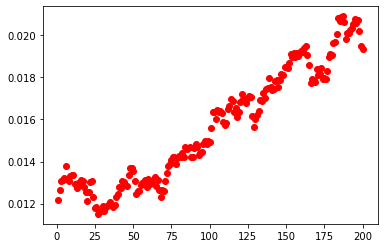

In [20]:
plt.plot(xtt,jun1,'ro')

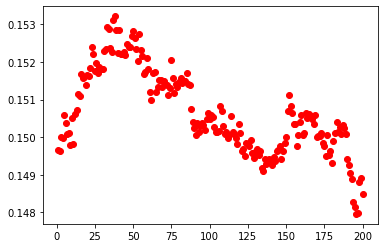

In [21]:
plt.plot(xtt,jun2,'ro')

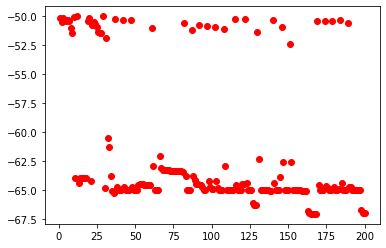

In [22]:
plt.plot(xtt,jun3,'ro')

In [23]:
jj1=nnn[498,:,:]
pingjun=np.mean(jj1,axis=0)

IndexError: index 498 is out of bounds for axis 0 with size 200

In [ ]:
print(pingjun)

In [ ]:
print(jun3[1198],jun1[1198],jun2[1198])

In [ ]:
print(nnn[1198,:,:])